In [1]:
from fastai.vision import *
import pretrainedmodels

In [2]:
import fastai.utils.collect_env
fastai.utils.collect_env.check_perf()

Running performance checks.

*** libjpeg-turbo status
❓ libjpeg-turbo's status can't be derived - need Pillow(-SIMD)? >= 5.4.0 to tell, current version 5.3.0.post1

*** Pillow-SIMD status
✔ Running Pillow-SIMD 5.3.0.post1

*** CUDA status
✔ Running the latest CUDA 9.0.176 with NVIDIA driver 396.54

Refer to https://docs.fast.ai/performance.html to make sense out of these checks and suggestions.


In [3]:
torch.cuda.empty_cache()

### Check dataset 

In [4]:
path = Path('data/ILSVRC/Data/CLS-LOC')

In [5]:
os.listdir(path)

['models', 'test', 'train', 'valid']

In [6]:
len(os.listdir(path/'train'))

1000

In [7]:
os.listdir(path/'train')[:5]

['n02093859', 'n01440764', 'n01443537', 'n01484850', 'n01491361']

In [8]:
len(os.listdir(path/'valid'))

1000

In [9]:
os.listdir(path/'valid')[:5]

['n02356798', 'n02361337', 'n02363005', 'n02364673', 'n02389026']

In [10]:
len(os.listdir(path/'test'))

100000

In [11]:
os.listdir(path/'test')[:5]

['ILSVRC2012_test_00026354.JPEG',
 'ILSVRC2012_test_00000007.JPEG',
 'ILSVRC2012_test_00000008.JPEG',
 'ILSVRC2012_test_00000009.JPEG',
 'ILSVRC2012_test_00000010.JPEG']

### for creating the file structure (only valid images because train was correct)

In [12]:
#os.rename(path/'val', path/'valid')
#
#train_classes = os.listdir(path/'train')
#
#for line in open('data/valid.txt'):
#    valid_path = path/'valid'/line.split(' ')[0]
#    valid_class = line.split(' ')[1].replace('\n','')
#    real_class = train_classes[int(valid_class)]
#    if not os.path.isdir(path/'valid'/real_class):
#        os.mkdir(path/'valid'/real_class)
#    os.rename(valid_path, path/'valid'/real_class/line.split(' ')[0])

In [13]:
# could improve performance (not tested with fastai)
torch.backends.cudnn.enabled = True 

### define metric 

In [14]:
def top_5_accuracy(input, targs, k=5):
    return top_k_accuracy(input, targs, k)

### create databunch from folder structure (training with 50% of imagenet, 128px)

In [15]:
train = ImageList.from_folder(path).filter_by_rand(0.5, seed=21)

In [16]:
train

ImageList (714247 items)
Image (3, 500, 375),Image (3, 500, 500),Image (3, 272, 396),Image (3, 399, 500),Image (3, 492, 500)
Path: data/ILSVRC/Data/CLS-LOC

## filter by size

In [17]:
asdf = ImageList.from_folder(path)

asdf 

ImageList (1431167 items)
Image (3, 500, 375),Image (3, 500, 500),Image (3, 333, 500),Image (3, 272, 396),Image (3, 375, 500)
Path: data/ILSVRC/Data/CLS-LOC

In [19]:
def filter_by_size(item):
    shape = list(open_image(item).shape)
    return True if shape[1] > 192 and shape[2] > 192 else False

In [ ]:
def filter_by_size(item):
    shape = list(open_image(item).shape)
    return True if shape[1] > 299 and shape[2] > 299 else False

In [21]:
train = ImageList.from_folder(path).filter_by_func(filter_by_size)

In [ ]:
train

In [19]:
data_bunch = (train.split_by_folder().label_from_folder()) \
                   .transform(get_transforms(), size=192) \
                   .databunch(num_workers=8, bs=64) \
                   .normalize(imagenet_stats)

In [20]:
# this is for the full imagenet dataset
#data_bunch = ImageDataBunch.from_folder(path, ds_tfms=get_transforms(), size=164, num_workers=8, bs=132) \
#                           .normalize(imagenet_stats)

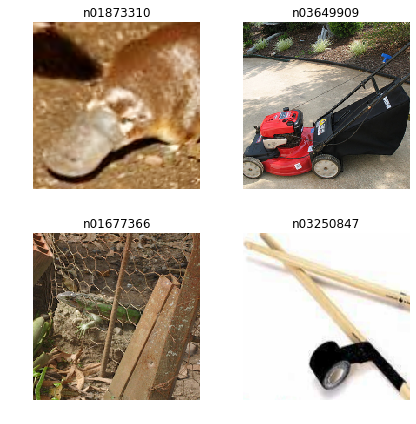

In [21]:
data_bunch.show_batch(rows=2, figsize=(6,6))

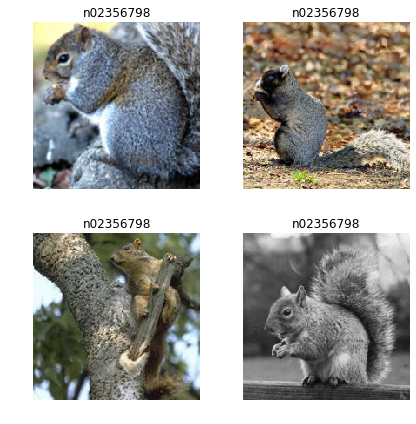

In [22]:
data_bunch.show_batch(rows=2, figsize=(6,6), ds_type=DatasetType.Valid)

### create learner with se-resnext50 (the pytorch model is already pretrained on imagenet)

In [19]:
def se_resnext50(pretrained=True):
    pretrained = 'imagenet' if pretrained else None
    model = pretrainedmodels.se_resnext50_32x4d(pretrained=pretrained)
    return model

In [20]:
learn = create_cnn(data_bunch, se_resnext50, pretrained=False,
                   cut=-2, split_on=lambda m: (m[0][3], m[1]))

/home/dollofcuty/anaconda3/envs/fastai_updated/lib/python3.7/site-packages/fastai/vision/learner.py:105: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


In [21]:
learn.layer_groups

[Sequential(
   (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU(inplace)
   (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
   (4): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
   (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (8): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (10): ReLU(inplace)
   (11): AdaptiveAvgPool2d(output_size=1)
   (12): Conv2d(256, 16, kernel_size=(1, 1), stride=(1, 1))
   (13): ReLU(inplace)
   (14): Conv2d(16, 256, kernel_size=(1, 1), stride=(

In [22]:
learn.metrics=[top_5_accuracy, accuracy]

In [23]:
learn.freeze()

In [24]:
apply_init(learn.model[1], nn.init.kaiming_normal_)

In [25]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


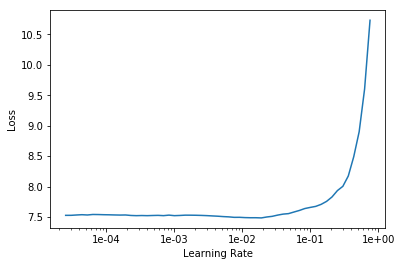

In [26]:
learn.recorder.plot(30)

In [28]:
lr = 1e-2

In [29]:
learn.fit_one_cycle(10, max_lr=lr, div_factor=50)

epoch,train_loss,valid_loss,top_5_accuracy,accuracy,time
0,6.862601,6.665904,0.030752,0.009156,11:25
1,6.279858,6.180989,0.077826,0.024283,11:08
2,5.956680,5.820145,0.123806,0.039212,11:11
3,5.692089,5.591760,0.155553,0.051652,11:08
4,5.539439,5.378475,0.188097,0.066779,11:07


KeyboardInterrupt: 

In [ ]:
learn.save('64px_res50_frozen');

In [18]:
learn.load('64px_res50_frozen');

In [19]:
learn.unfreeze()

In [19]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


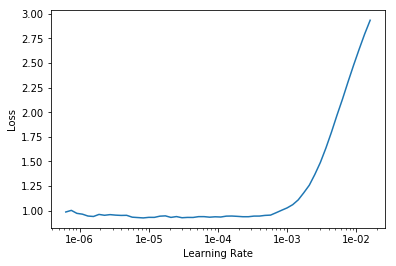

In [20]:
learn.recorder.plot()

In [20]:
lr = 3e-4

In [21]:
lrs = learn.lr_range(slice(lr/60,lr))
lrs

array([5.000000e-06, 3.872983e-05, 3.000000e-04])

epoch,train_loss,valid_loss,top_5_accuracy,accuracy,time
0,1.032979,1.193163,0.904220,0.711900,1:55:44
1,1.079330,1.190444,0.902780,0.713420,1:55:25
2,0.944056,1.149293,0.908180,0.721860,1:55:23
3,0.845834,1.115926,0.912320,0.732440,1:55:16
4,0.766908,1.109353,0.913600,0.736340,1:55:17


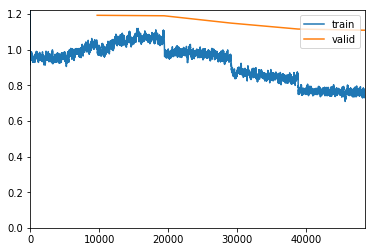

In [22]:
learn.fit_one_cycle(5, max_lr=lrs, div_factor=50)

In [23]:
learn.save('64px_res50');

### scale up image size to 299

In [ ]:
train = ImageList.from_folder(path).filter_by_rand(0.5, seed=21)

data_bunch = (train.split_by_folder().label_from_folder()) \
                   .transform(get_transforms(), size=299) \
                   .databunch(num_workers=8, bs=32) \
                   .normalize(imagenet_stats)

In [15]:
learn = cnn_learner(data_bunch, models.resnet50, pretrained=True, callback_fns=[ShowGraph])

In [16]:
learn.metrics=[top_5_accuracy, accuracy]

In [17]:
learn.freeze()

In [18]:
learn.load('64px_res50');

In [19]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


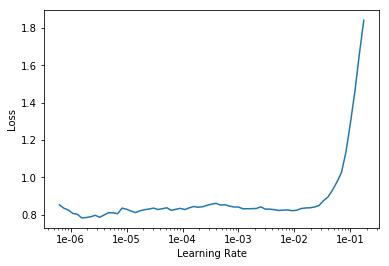

In [20]:
learn.recorder.plot()

In [21]:
lr = 1e-2

epoch,train_loss,valid_loss,top_5_accuracy,accuracy,time
0,1.158917,1.298977,0.906700,0.715020,2:36:03
1,1.255340,1.331895,0.903760,0.707680,2:35:57
2,1.105724,1.224702,0.912420,0.726360,2:35:58
3,0.833184,1.085367,0.925460,0.753520,2:36:02
4,0.725418,1.013424,0.931440,0.767460,2:36:11


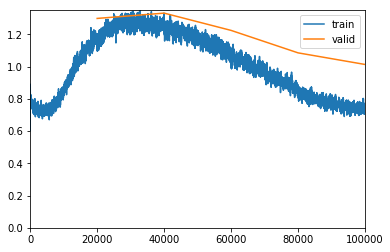

In [22]:
learn.fit_one_cycle(5, max_lr=slice(lr), div_factor=30)

In [23]:
learn.save('255px_res50_frozen')

In [17]:
learn.load('255px_res50_frozen');

Learner(data=ImageDataBunch;

Train: LabelList (1281167 items)
x: ImageList
Image (3, 255, 255),Image (3, 255, 255),Image (3, 255, 255),Image (3, 255, 255),Image (3, 255, 255)
y: CategoryList
n02093859,n02093859,n02093859,n02093859,n02093859
Path: data/ILSVRC/Data/CLS-LOC;

Valid: LabelList (50000 items)
x: ImageList
Image (3, 255, 255),Image (3, 255, 255),Image (3, 255, 255),Image (3, 255, 255),Image (3, 255, 255)
y: CategoryList
n02356798,n02356798,n02356798,n02356798,n02356798
Path: data/ILSVRC/Data/CLS-LOC;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(6

In [18]:
learn.unfreeze()

In [19]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


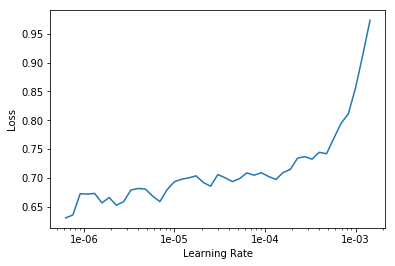

In [20]:
learn.recorder.plot()

In [ ]:
lr = 2e-4

In [ ]:
lrs = learn.lr_range(slice(lr/5,lr))

In [ ]:
learn.fit_one_cycle(4, max_lr=lrs)

In [ ]:
learn.save('255px_res50')

## prediction 

In [12]:
cl, label, prob = learn.predict(img)

In [8]:
learn.export('export/export.pkl')

In [9]:
learn = load_learner('export')

In [12]:
# Load Imagenet Synsets
with open('data/imagenet_synsets.txt', 'r') as f:
    synsets = f.readlines()

# len(synsets)==1001
# sysnets[0] == background
synsets = [x.strip() for x in synsets]
splits = [line.split(' ') for line in synsets]
key_to_classname = {spl[0]:' '.join(spl[1:]) for spl in splits}

with open('data/imagenet_classes.txt', 'r') as f:
    class_id_to_key = f.readlines()

class_id_to_key = np.array([x.strip() for x in class_id_to_key])

In [13]:
len(class_id_to_key), len(key_to_classname)

(1000, 1861)

In [14]:
key_to_classname

{'?????????': 'dummy class for index 0',
 'n02119789': 'kit fox, Vulpes macrotis',
 'n02100735': 'English setter',
 'n02110185': 'Siberian husky',
 'n02096294': 'Australian terrier',
 'n02102040': 'English springer, English springer spaniel',
 'n02066245': 'grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus',
 'n02509815': 'lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens',
 'n02124075': 'Egyptian cat',
 'n02417914': 'ibex, Capra ibex',
 'n02123394': 'Persian cat',
 'n02125311': 'cougar, puma, catamount, mountain lion, painter, panther, Felis concolor',
 'n02423022': 'gazelle',
 'n02346627': 'porcupine, hedgehog',
 'n02077923': 'sea lion',
 'n02110063': 'malamute, malemute, Alaskan malamute',
 'n02447366': 'badger',
 'n02109047': 'Great Dane',
 'n02089867': 'Walker hound, Walker foxhound',
 'n02102177': 'Welsh springer spaniel',
 'n02091134': 'whippet',
 'n02092002': 'Scottish deerhound, deerhound',
 'n02071294': 'killer whale, killer, or

In [15]:
class_id_to_key

array(['n01440764', 'n01443537', 'n01484850', 'n01491361', ..., 'n13052670', 'n13054560', 'n13133613', 'n15075141'],
      dtype='<U9')

In [16]:
classes = [key_to_classname[key] for key in class_id_to_key]

In [17]:
len(classes), classes[:5]

(1000,
 ['tench, Tinca tinca',
  'goldfish, Carassius auratus',
  'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
  'tiger shark, Galeocerdo cuvieri',
  'hammerhead, hammerhead shark'])